In [2]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import choice
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 10, 20

# pip install numpy pandas matplotlib tqdm seaborn 

%matplotlib inline

In [131]:
def type_a(subsequence, true_conversions):
    """
    This user will download the first app she likes
    This type of user will take decisions based
    on the following algorithm:
    (a) Do I like the first app I see?
    (b) If yes, download, else scroll one app and go back to (a)
    """
    conversion = np.zeros(N_APPS)
    impressions = np.zeros(N_APPS)
    
    for _ in range(N_USERS):
        for idx, el in enumerate(subsequence):
            impressions[idx] += 1
            if random.random() > true_conversions[el]:
                continue
            else:
                conversion[idx] += 1
                break
    return conversion, impressions

def type_b(subsequence, true_conversions, scale_theta):
    """
    Type B: Normally curious user.
    This user will scroll a bit, compare various
    apps and download the one she likes the most.
    Note that different users have different preferences.
    This type of user will take decisions based
    on the following algorithm:
    (1) Scroll theta apps
    (2) Then install the app she likes the most
    """
    conversion = np.zeros(N_APPS)
    impressions = np.zeros(N_APPS)

    for _ in range(N_USERS):
        theta = int(min(N_APPS-1, max(1, np.random.exponential(scale=scale_theta))))
        best_idx = choice(subsequence[:theta], 1, p=(true_conversions[:theta] / true_conversions[:theta].sum()))[0]
        conversion[best_idx] += 1
        for i in range(theta):
            impressions[i] += 1
    return conversion, impressions

def type_c(subsequence, true_conversions, scale_theta, min_delta=0.1):
    """
    Type C: Very curious user.
    This user will scroll a bit, compare various
    apps and download all those she thinks are relevant.
    Note that different users have different preferences.
    This type of user will take decisions based
    on the following algorithm:
    (1) Scroll theta apps
    (2) Then install all apps that are relevant
    """
    conversion = np.zeros(N_APPS)
    impressions = np.zeros(N_APPS)

    for _ in range(N_USERS):
        theta = int(min(N_APPS-1, max(1, np.random.exponential(scale=scale_theta))))
        for idx, score in list(enumerate(subsequence))[:theta]:
            impressions[idx] += 1
            if score > min_delta:
                conversion[idx] += 1
    return conversion, impressions


def simulate(alpha, beta, gamma, mean_tau, std_tau, scale_theta, min_delta):
    """
    Simulates the App Store
    
    Params:
    alpha: percentage of type A users
    beta: percentage of type B users
    gamma: percentage of type C users
    mean_tau: center of the true conversion distribution
    std_tau: std dev of the true conversion distribution
    scale_theta: scale of the scroll parameter distribution
     only used for type b/c users
    min_delta: minimum relevance for a type c user to download
     and app.
    """
    
    app_ids = list(range(N_APPS))
    all_dls, all_imp = np.zeros(N_APPS), np.zeros(N_APPS)
    for i in tqdm(range(N_SEARCHES)):
        true_conversions = np.random.normal(mean_tau, std_tau, size=N_APPS)
        searches_results = np.array(app_ids)
        searches_conversion = []
        searches_impressions = []
        observed_conversions = []

        dls_a, imp_a = type_a(searches_results, true_conversions)
        dls_b, imp_b = type_b(searches_results, true_conversions, scale_theta=scale_theta)
        dls_c, imp_c = type_c(searches_results, true_conversions, scale_theta=scale_theta, min_delta=min_delta)

        all_dls += alpha * dls_a + beta * dls_b + gamma * dls_c
        all_imp += alpha * imp_a + beta * imp_b + gamma * imp_c
    
    all_conv = (all_dls / all_imp)    
    return all_dls, all_conv, all_imp

In [132]:
# Store parameters
N_APPS = 30
N_SEARCHES = 100
N_USERS = 100

# Population distribution (Type A, Type B, Type C)
alpha, beta, gamma = 0.4, 0.6, 0.0

# True conversion distribution
mean_tau, std_tau = 0.8, 0.05

# Scroll parameters (min/max theta)
# This is a parameter representing the number of apps in the scroll surface of a TYPE B user.
scale_theta = 3 # IOS10 empirical values
# scale_theta = 3*1.4 # IOS11 empirical values

# Type C min threshold parameter
min_delta = 0.05

ios_11_dwls, ios_11_convs, ios_11_imps = simulate(alpha, beta, gamma, mean_tau, std_tau, scale_theta*1.4, min_delta)
ios_10_dwls, ios_10_convs, ios_10_imps = simulate(alpha, beta, gamma, mean_tau, std_tau, scale_theta, min_delta)

100%|██████████| 100/100 [00:00<00:00, 122.65it/s]
/Users/luca/.virtualenvs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:99: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 100/100 [00:00<00:00, 131.36it/s]


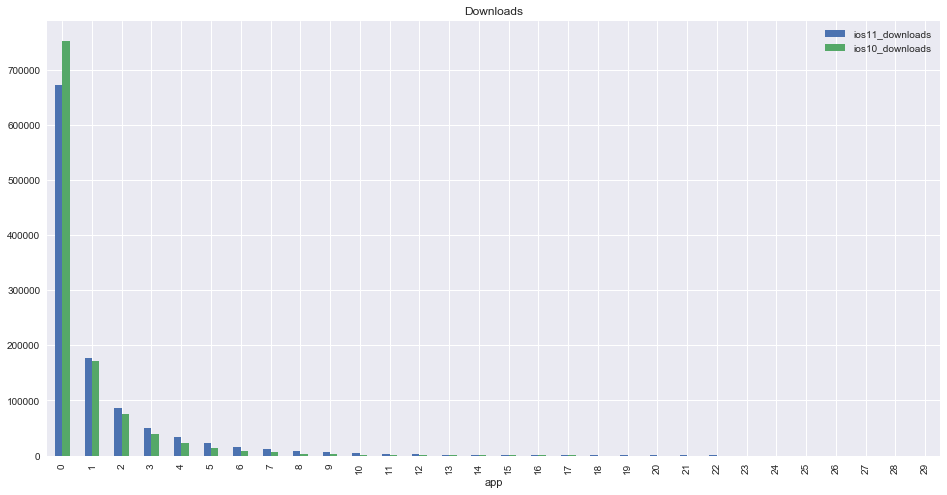

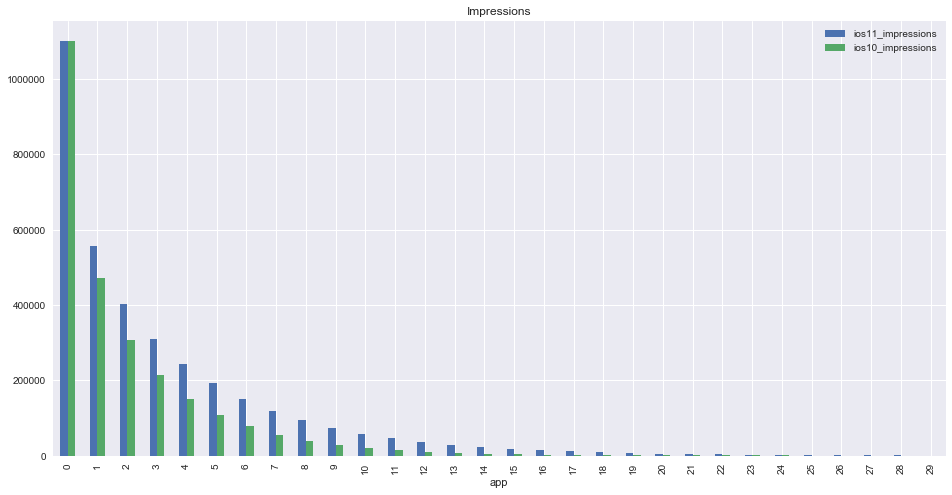

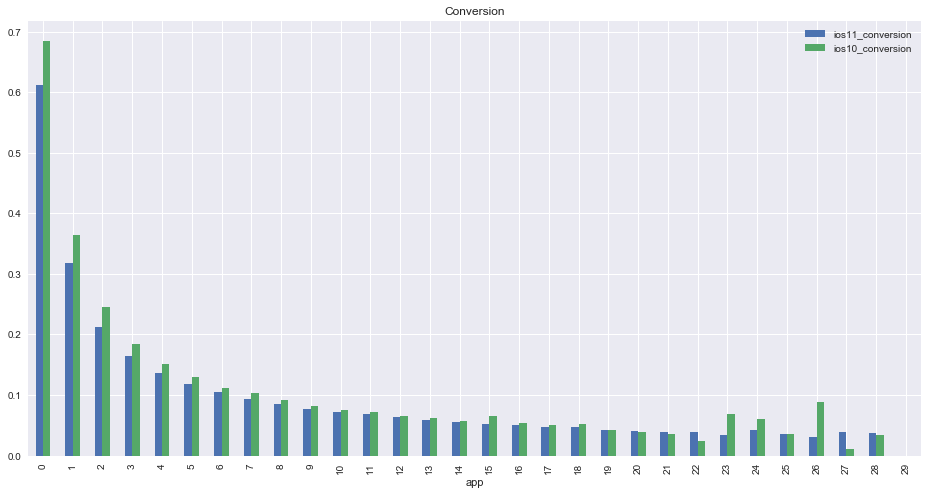

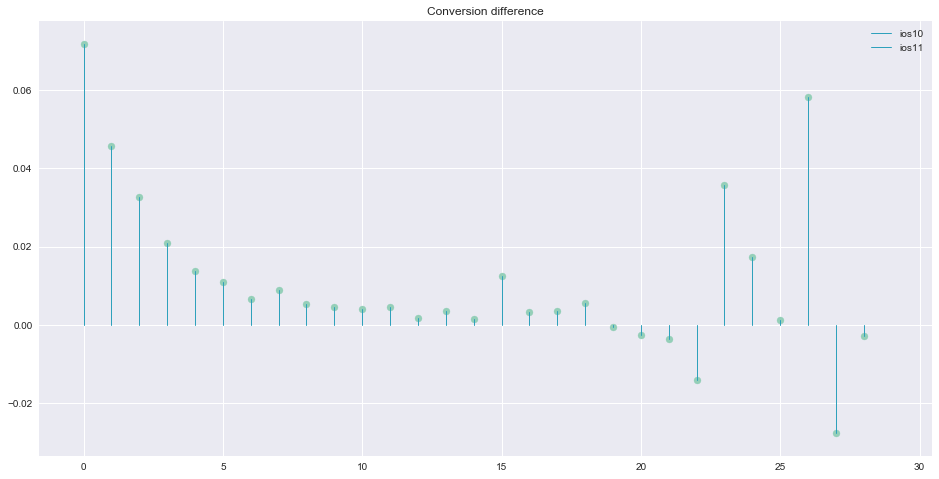

In [127]:
df_dls = pd.DataFrame(list(zip(*[ios_11_dwls, ios_10_dwls])))
df_dls.index.name = 'app'
df_dls.rename(columns={0: 'ios11_downloads', 1: 'ios10_downloads'}, inplace=True)
df_dls.plot(kind='bar', figsize=(16,8))
plt.title("Downloads")

df_imp = pd.DataFrame(list(zip(*[ios_11_imps, ios_10_imps])))
df_imp.index.name = 'app'
df_imp.rename(columns={0: 'ios11_impressions', 1: 'ios10_impressions'}, inplace=True)
df_imp.plot(kind='bar', figsize=(16,8))
plt.title("Impressions")

df_conv = pd.DataFrame(list(zip(*[ios_11_convs, ios_10_convs])))
df_conv.index.name = 'app'
df_conv.rename(columns={0: 'ios11_conversion', 1: 'ios10_conversion'}, inplace=True)
df_conv.plot(kind='bar', figsize=(16,8))
plt.title("Conversion")

fig = plt.figure(figsize=(16,8))
fig = plt.subplot()

points = []
for jdx, (idx, row) in enumerate(df_conv.iterrows()):
    points.append(row['ios10_conversion'] - row['ios11_conversion'])
    plt.plot((jdx, jdx), (points[-1], 0), 'k-', lw=1, color='#2fa1bc')

plt.scatter(np.arange(N_APPS), points, color="#94cfb8")
#plt.scatter(np.arange(N_APPS), , color="#a8eb7a")
plt.title("Conversion difference")
plt.legend(["ios10","ios11"])